In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Birleştirilmiş veri setini yükle
df_multi = pd.read_csv('combined_dataset.csv', index_col='index', parse_dates=True)

# 2. Eksik verileri doldur
df_multi.interpolate(method='linear', inplace=True)

# 3. Veriyi Eğitim ve Validasyon olarak ayır
split_date = '2019-01-01'
train_multi = df_multi.loc[df_multi.index < split_date]
val_multi = df_multi.loc[df_multi.index >= split_date]

# 4. Veriyi Ölçeklendir (Tüm Sütunlar)
# Multivariate scaler için yeni bir obje oluşturalım
scaler_multi = StandardScaler()
scaled_train_multi = scaler_multi.fit_transform(train_multi)
scaled_val_multi = scaler_multi.transform(val_multi)

print("Çok değişkenli veri başarıyla yüklendi ve hazırlandı.")
print(f"Eğitim verisi şekli: {scaled_train_multi.shape}")
print(f"Validasyon verisi şekli: {scaled_val_multi.shape}")

Çok değişkenli veri başarıyla yüklendi ve hazırlandı.
Eğitim verisi şekli: (8493, 5)
Validasyon verisi şekli: (2344, 5)


In [10]:
def create_sequences(data, n_past, n_future):
    X, y = [], []
    # Hedef değişkenimiz her zaman ilk sütun ('stage_m')
    target_col_index = 0 
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, :]) # Tüm özellikleri al
        y.append(data[i + n_future - 1, target_col_index])
    return np.array(X), np.array(y)

# Geçmiş gün sayısı (univariate model ile aynı tutalım)
N_PAST = 7
N_FUTURE = 1

# Dizileri oluşturalım
X_train_multi, y_train_multi = create_sequences(scaled_train_multi, N_PAST, N_FUTURE)
X_val_multi, y_val_multi = create_sequences(scaled_val_multi, N_PAST, N_FUTURE)

print(f"\nOluşturulan Çok Değişkenli Dizi Şekilleri:")
print(f"X_train_multi şekli: {X_train_multi.shape}") # (örnek, 7 gün, 5 özellik)
print(f"y_train_multi şekli: {y_train_multi.shape}")
print(f"X_val_multi şekli: {X_val_multi.shape}")
print(f"y_val_multi şekli: {y_val_multi.shape}")


Oluşturulan Çok Değişkenli Dizi Şekilleri:
X_train_multi şekli: (8486, 7, 5)
y_train_multi şekli: (8486,)
X_val_multi şekli: (2337, 7, 5)
y_val_multi şekli: (2337,)


In [11]:
# Univariate modelden gelen en iyi hiperparametreler
BEST_UNITS = 128
BEST_DROPOUT_RATE = 0.2
BEST_LEARNING_RATE = 0.001
BEST_BATCH_SIZE = 64

# Modeli oluşturalım (yapı tamamen aynı)
multi_model = Sequential([
    LSTM(units=BEST_UNITS, activation='relu', input_shape=(X_train_multi.shape[1], X_train_multi.shape[2])),
    Dropout(rate=BEST_DROPOUT_RATE),
    Dense(units=1) 
])

# Modeli derleyelim
optimizer = tf.keras.optimizers.Adam(learning_rate=BEST_LEARNING_RATE)
multi_model.compile(optimizer=optimizer, loss='mean_squared_error')

multi_model.summary()

# Callbacks (yeni bir kayıt dosyası adı ile)
early_stopping_multi = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint_multi = ModelCheckpoint(filepath='best_multivariate_model.keras', save_best_only=True, monitor='val_loss')

# Modeli eğitelim
history_multi = multi_model.fit(
    X_train_multi,
    y_train_multi,
    epochs=200,
    batch_size=BEST_BATCH_SIZE,
    validation_data=(X_val_multi, y_val_multi),
    callbacks=[early_stopping_multi, model_checkpoint_multi],
    verbose=1
)

/home/yasirgunes/bitirme/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,737 (268.50 KB)

 Trainable params: 68,737 (268.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.4616 - val_loss: 0.2461
Epoch 2/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2080 - val_loss: 0.1885
Epoch 3/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1795 - val_loss: 0.1657
Epoch 4/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1621 - val_loss: 0.1574
Epoch 5/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1503 - val_loss: 0.1519
Epoch 6/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1427 - val_loss: 0.1483
Epoch 7/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1358 - val_loss: 0.1475
Epoch 8/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1426 - val_loss: 0.1477
Epoch 9/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1436 - val_loss: 0.1449
Epoch 10/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1384 - val_loss: 0.1529
Epoch 11/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1361 - val_loss: 0.1491
Epoch 12/200
133/133 ━━━━━━━━━━━━━━━━

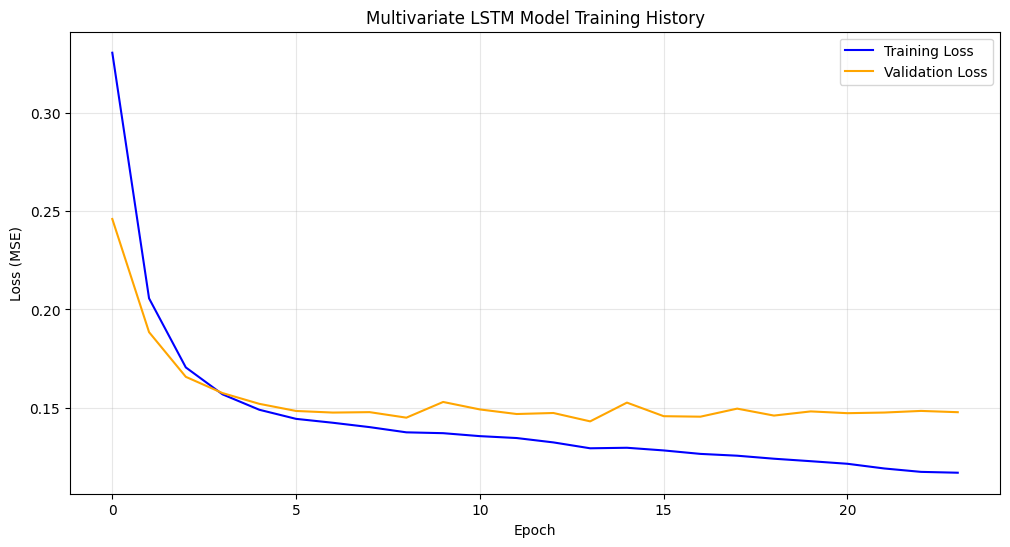

Total training epochs: 24
Minimum validation loss: 0.143007
Epoch with minimum validation loss: 14


In [13]:
# Visualize the multivariate model training history
plt.figure(figsize=(12, 6))
plt.plot(history_multi.history['loss'], label='Training Loss', color='blue')
plt.plot(history_multi.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Multivariate LSTM Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total training epochs: {len(history_multi.history['loss'])}")
print(f"Minimum validation loss: {min(history_multi.history['val_loss']):.6f}")
print(f"Epoch with minimum validation loss: {history_multi.history['val_loss'].index(min(history_multi.history['val_loss'])) + 1}")



En iyi multivariate model yükleniyor...
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


--- PROJE FİNAL SONUÇLARI ---
                       Model  MAE (m)  RMSE (m)  R-Kare (R²)
0                   Baseline   0.1796    0.3591       0.7749
1  Optimized Univariate LSTM   0.1650    0.3117       0.8304
2          Multivariate LSTM   0.1510    0.2908       0.8530


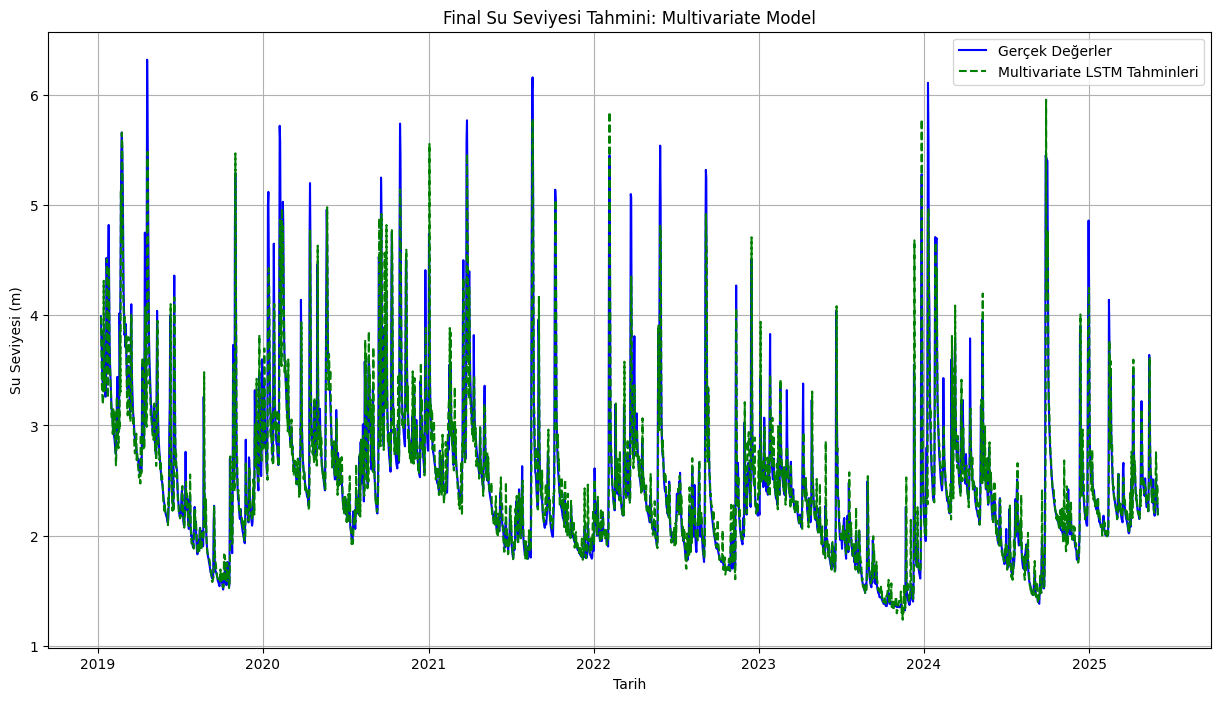

In [12]:
# Kaydedilen en iyi multivariate modeli yükleyelim
print("\nEn iyi multivariate model yükleniyor...")
saved_best_multi_model = load_model('best_multivariate_model.keras')

# Tahmin yapalım (ölçekli)
predictions_scaled_multi = saved_best_multi_model.predict(X_val_multi)

# ÖNEMLİ: Tahminleri orijinal ölçeğe geri döndürme
# Scaler 5 özellik beklediği için, tahminlerimizi (1 özellik) scaler'a uygun hale getirmeliyiz.
# Geçici bir "dummy" array oluşturup tahminlerimizi ilk sütuna yerleştirelim.
dummy_array = np.zeros((len(predictions_scaled_multi), scaled_train_multi.shape[1]))
dummy_array[:, 0] = predictions_scaled_multi.flatten()
predictions_original_multi = scaler_multi.inverse_transform(dummy_array)[:, 0]

# Gerçek değerleri de orijinal ölçeğe dönüştürelim
# ÖNEMLİ: y_val_multi ile predictions_scaled_multi aynı boyutta olmalı
dummy_array_true = np.zeros((len(y_val_multi), scaled_train_multi.shape[1]))
dummy_array_true[:, 0] = y_val_multi
y_true_original_multi = scaler_multi.inverse_transform(dummy_array_true)[:, 0]

# Metrikleri hesaplayalım
mae_multi = mean_absolute_error(y_true_original_multi, predictions_original_multi)
rmse_multi = np.sqrt(mean_squared_error(y_true_original_multi, predictions_original_multi))
r2_multi = r2_score(y_true_original_multi, predictions_original_multi)

# --- FİNAL SONUÇ TABLOSU ---
# Baseline ve Univariate LSTM sonuçlarını diğer notebook'tan ekleyelim
mae_baseline = 0.1796  # train.ipynb Cell 4'ten
rmse_baseline = 0.3591
r2_baseline = 0.7749

mae_final = 0.1650  # train.ipynb Cell 7'den
rmse_final = 0.3117
r2_final = 0.8304

results_summary = pd.DataFrame({
    'Model': ['Baseline', 'Optimized Univariate LSTM', 'Multivariate LSTM'],
    'MAE (m)': [mae_baseline, mae_final, mae_multi],
    'RMSE (m)': [rmse_baseline, rmse_final, rmse_multi],
    'R-Kare (R²)': [r2_baseline, r2_final, r2_multi]
})

print("\n\n--- PROJE FİNAL SONUÇLARI ---")
print(results_summary.round(4))

# Görselleştirme
val_dates_multi = df_multi[df_multi.index >= split_date].index[N_PAST:]
plt.figure(figsize=(15, 8))
plt.plot(val_dates_multi, y_true_original_multi, label='Gerçek Değerler', color='blue')
plt.plot(val_dates_multi, predictions_original_multi, label='Multivariate LSTM Tahminleri', color='green', linestyle='--')
plt.title('Final Su Seviyesi Tahmini: Multivariate Model')
plt.xlabel('Tarih')
plt.ylabel('Su Seviyesi (m)')
plt.legend()
plt.grid(True)
plt.show()